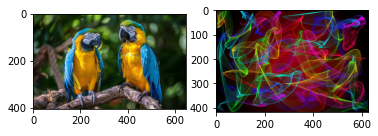

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

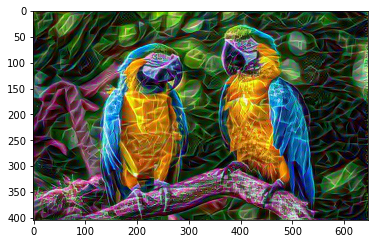

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import tensorflow as tf
from tensorflow import keras

img = Image.open('img.jpg') #фото, на которое накладывается стиль
img_style = Image.open('img_style.jpg') #стиль, который нужно наложить

plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()

#преобразуем в нужный для нейронной сети формат
x_img = keras.applications.vgg19.preprocess_input( np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

#функция которая преобразует фото из рбг в ргб
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0) #убираем нулевую ось
        assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

#Слой содержимого, на котором будут отображаться карты объектов
content_layers = ['block5_conv2'] 

#слои стиля
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

print(vgg.input)
for m in model_outputs:
    print(m)

model = keras.models.Model(vgg.input, model_outputs)
for layer in model.layers:
    layer.trainable = False

print(model.summary()) # вывод структуры НС в консоль

def get_feature_representations(model):
    style_outputs = model(x_style)
    content_outputs = model(x_img)
  
    #получаем представление функций стиля и контента из нашей модели
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

#потери по контенту
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

#матрица грамма для тензора
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

#стиль для строго определенного слоя нейронной сети
def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
  
    return tf.reduce_mean(tf.square(gram_style - gram_target))

#вычисляем все потери
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights # альфа и бета
  
    model_outputs = model(init_image)
  
    #выделяем карты признака для стила и для контента
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
  
    #величины потерь
    style_score = 0
    content_score = 0

    #накапливать потери стиля со всех слоев
    #одинаково взвешиваем вклад каждого слоя потерь
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    #умножаем на альфа и бета
    style_score *= style_weight
    content_score *= content_weight

    #получаем полные потери
    loss = style_score + content_score 
    return loss, style_score, content_score

num_iterations=100 #число итераций
content_weight=1e3 #насколько важен контент
style_weight=1e-2 #параметр бета

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features] #матрица грамма для стиля

#создаем копию изображения и преобразуем его в формат, который видит tenserflow
init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

#оптимизатор для алгоритма градиентного спуска
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight) #коллекция из лучших элементов

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

#параметры для бгр в ргб
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = [] #все изображения которые мы сформируем в процессе алгоритма

#алгоритм градиентного спуска (формирование стиллизованного изображения)
for i in range(num_iterations):
    with tf.GradientTape() as tape: #записывает все значения, чтобы мы потом могли вычислить градиент для
        #изменения пикселей формируемого изображения в соответствии с функцией потерь
        all_loss = compute_loss(**cfg) #пропускает изображение через нейронную сеть и возвращает значения потерь
    
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image) 
    
    opt.apply_gradients([(grads, init_image)]) #применяем вычисленный градиент к пикселям нашего изображения
    clipped = tf.clip_by_value(init_image, min_vals, max_vals) #ограничиваем пиксель нашего изображения
    #минимальными и максимальными значениями
    init_image.assign(clipped)
    
    #проверяем для какого изображения получились наименьшие потери и их сохраняем
    if loss < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = loss
        best_img = deprocess_img(init_image.numpy())

        plot_img = deprocess_img(init_image.numpy())
        imgs.append(plot_img)
        print('Iteration: {}'.format(i))

plt.imshow(best_img)
print(best_loss)

image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save("result.jpg")